# Custom MLP Prediction Implementation

## Cleaning Up & Visualisation

1. Replace the NA values with the mean of the columns
1. Getting the top 5 parameters
1. Displaying the impact of the top 5 parameters

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class TabularDataset(Dataset):
    def __init__(self, path):
        df = pd.read_csv(path)
        df.fillna(df.mean(), inplace=True)
        data = df.values.astype('float32')
        self.X = torch.tensor(data[:, :-1])
        self.y = torch.tensor(data[:, -1]).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

loader = DataLoader(TabularDataset('framingham.csv'), batch_size=32, shuffle=True)

age             0.225408
sysBP           0.216374
prevalentHyp    0.177458
diaBP           0.145112
glucose         0.120451
Name: TenYearCHD, dtype: float64


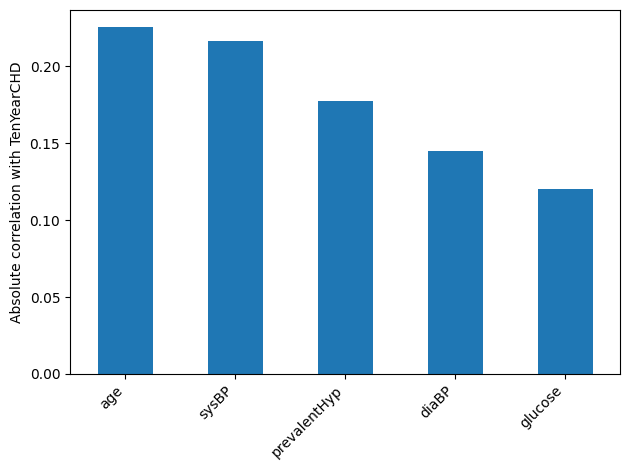

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('framingham.csv')
df.fillna(df.mean(), inplace=True)
corr = df.corr()['TenYearCHD'].abs().drop('TenYearCHD')
top5 = corr.sort_values(ascending=False).head(5)

print(top5)

top5.plot.bar()
plt.ylabel('Absolute correlation with TenYearCHD')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Preliminary Data Analysis

## Data Imbalance Through Raw Analysis

CHD Negative: 3596 (84.811%)
CHD Positive: 644 (15.189%)


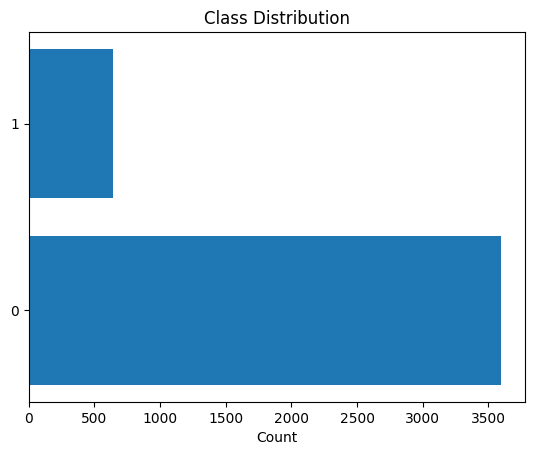

In [3]:
import numpy as np
def plot_class_distribution(loader):
    from collections import Counter
    name_map = {
        0: 'CHD Negative',
        1: 'CHD Positive'
    }
    labels = []
    for _, y in loader:
        labels.extend(y.numpy())
    counts = Counter(labels)
    classes = sorted(counts)
    freqs = np.array([counts[c] for c in classes])
    total = sum(freqs)
    for c, f in zip(classes, freqs):
        print(f'{name_map[c]}: {f} ({f/total:.3%})')
    plt.barh([str(c) for c in classes], freqs)
    plt.xlabel('Count')
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(loader)

## Data Imbalance through MLP Predictor

### Defining a MLP Predictor

- We based our MLP based on research from [Nature/Subash Mondal et. al](https://www.nature.com/articles/s41598-025-85765-x.pdf)

- The evaluators recommended we use softmax during the poster presentations, but for binary classification a sigmoid evaluation is the industry standard method, so we stuck with it since using softmax is numerically unstable for binary classfication.

In [4]:
import torch.nn as nn

class ECE228MLP(nn.Module):
    def __init__(self, input_dim):
        super(ECE228MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 265),
            nn.Sigmoid(),
            nn.Linear(265, 265),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(265, 128),
            nn.Sigmoid(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.Sigmoid(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

## Train + Evaluate Process

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

X_res = np.array([])
y_res = np.array([])

for X, y in loader:
    X_np = X.numpy()
    y_np = y.numpy()
    if X_res.size == 0:
        X_res = X_np
        y_res = y_np
    else:
        X_res = np.vstack((X_res, X_np))
        y_res = np.concatenate((y_res, y_np))
    
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 3392
Testing set size: 848


In [6]:
import torch.nn.functional as F
def default_train_and_plot(model, X, Y, epochs=100, lr=1e-4, batch_size=32):
    device = next(model.parameters()).device
    X, Y = X.to(device), Y.to(device).float()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    n = X.size(0)
    loss_hist, prec_hist, rec_hist = [], [], []

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(n, device=device)
        total_loss = tp = fp = fn = 0

        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            x_batch, y_batch = X[idx], Y[idx]
            optimizer.zero_grad()
            logits = model(x_batch).view(-1)
            loss = loss_fn(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x_batch.size(0)

            preds = (torch.sigmoid(logits) > 0.5).long()
            tp += ((preds == 1) & (y_batch == 1)).sum().item()
            fp += ((preds == 1) & (y_batch == 0)).sum().item()
            fn += ((preds == 0) & (y_batch == 1)).sum().item()

        loss_hist.append(total_loss / n)
        prec_hist.append(tp / (tp + fp) if tp + fp else 0)
        rec_hist.append(tp / (tp + fn) if tp + fn else 0)

    print(f"Final Loss: {loss_hist[-1]:.4f}, Precision: {prec_hist[-1]:.4f}, Recall: {rec_hist[-1]:.4f}")
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].plot(loss_hist);   axes[0].set(title='Loss',      xlabel='Epoch', ylabel='Loss')
    axes[1].plot(prec_hist);   axes[1].set(title='Precision', xlabel='Epoch')
    axes[2].plot(rec_hist);    axes[2].set(title='Recall',    xlabel='Epoch')
    plt.tight_layout()
    plt.show()

Final Loss: 0.3966, Precision: 0.5455, Recall: 0.0117


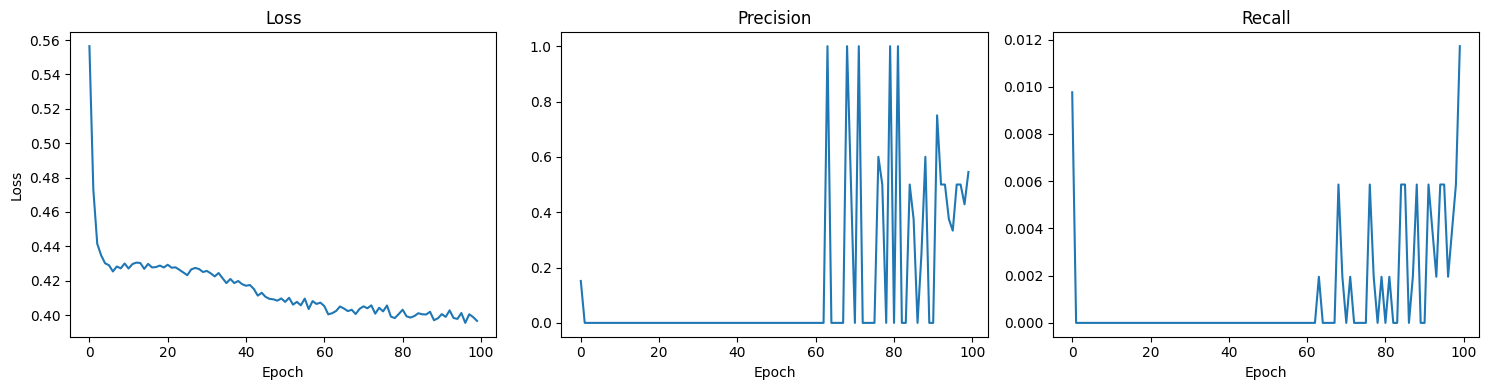

In [7]:
X_dim = next(iter(loader))[0].shape[1]
default_model = ECE228MLP(X_dim)
default_train_and_plot(default_model, X_train, y_train, epochs=100, lr=1e-4)

### Effect of L2 Regularisation

In [8]:
import torch.nn.functional as F
from tqdm import tqdm

def l2_train_and_plot(model, X, Y, epochs=100, lr=1e-4, batch_size=32):
    device = next(model.parameters()).device
    X, Y = X.to(device), Y.to(device).float()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    n = X.size(0)
    loss_hist, prec_hist, rec_hist = [], [], []

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        perm = torch.randperm(n, device=device)
        total_loss = tp = fp = fn = 0

        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            x_batch, y_batch = X[idx], Y[idx]
            optimizer.zero_grad()
            logits = model(x_batch).view(-1)
            loss = loss_fn(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x_batch.size(0)

            preds = (torch.sigmoid(logits) > 0.5).long()
            tp += ((preds == 1) & (y_batch == 1)).sum().item()
            fp += ((preds == 1) & (y_batch == 0)).sum().item()
            fn += ((preds == 0) & (y_batch == 1)).sum().item()

        loss_hist.append(total_loss / n)
        prec_hist.append(tp / (tp + fp) if tp + fp else 0)
        rec_hist.append(tp / (tp + fn) if tp + fn else 0)

    print(f"Final Loss: {loss_hist[-1]:.4f}, Precision: {prec_hist[-1]:.4f}, Recall: {rec_hist[-1]:.4f}")
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].plot(loss_hist);   axes[0].set(title='Loss',      xlabel='Epoch', ylabel='Loss')
    axes[1].plot(prec_hist);   axes[1].set(title='Precision', xlabel='Epoch')
    axes[2].plot(rec_hist);    axes[2].set(title='Recall',    xlabel='Epoch')
    plt.tight_layout()
    plt.show()

Training: 100%|██████████| 100/100 [00:07<00:00, 13.98it/s]


Final Loss: 0.3833, Precision: 0.4651, Recall: 0.0391


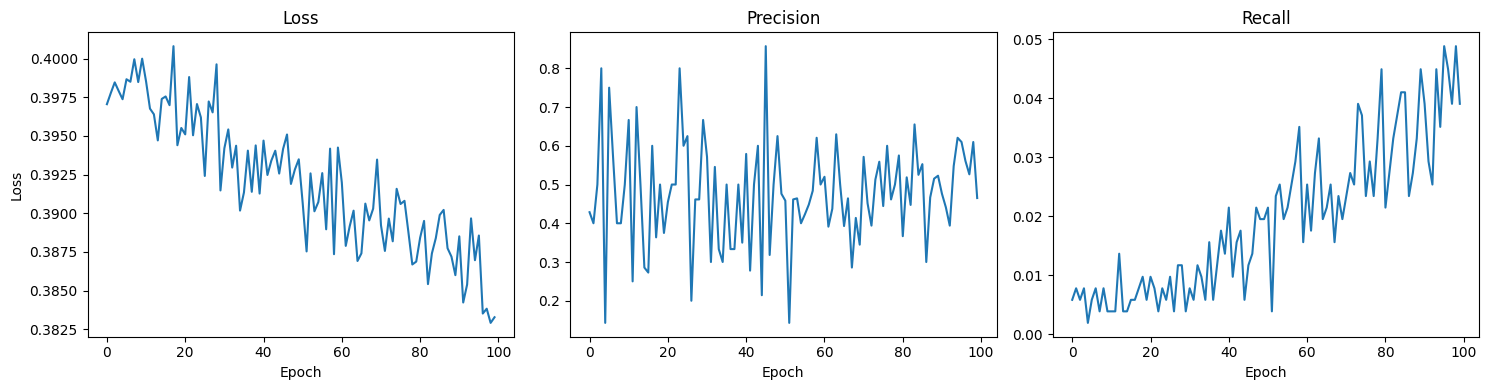

In [9]:
X_dim = next(iter(loader))[0].shape[1]
default_model_l2 = ECE228MLP(X_dim)
l2_train_and_plot(default_model, X_train, y_train, epochs=100, lr=1e-4)

In [10]:

def evaluate(model, X_test, Y_test, batch_size=32, finetuning=False):
    device = next(model.parameters()).device
    X_test, Y_test = X_test.to(device), Y_test.to(device).float()
    loss_fn = torch.nn.BCEWithLogitsLoss()
    n = X_test.size(0)
    total_loss = tp = tn = fp = fn = 0

    model.eval()
    with torch.no_grad():
        for i in range(0, n, batch_size):
            x_batch = X_test[i:i+batch_size]
            y_batch = Y_test[i:i+batch_size]
            logits = model(x_batch).view(-1)
            total_loss += loss_fn(logits, y_batch).item() * x_batch.size(0)
            preds = (torch.sigmoid(logits) > 0.5).long()

            tp += ((preds == 1) & (y_batch == 1)).sum().item()
            tn += ((preds == 0) & (y_batch == 0)).sum().item()
            fp += ((preds == 1) & (y_batch == 0)).sum().item()
            fn += ((preds == 0) & (y_batch == 1)).sum().item()

    loss = total_loss / n
    precision = tp / (tp + fp) if tp + fp else 0
    recall    = tp / (tp + fn) if tp + fn else 0
    accuracy  = (tp + tn) / n
    f1        = 2 * precision * recall / (precision + recall) if precision + recall else 0

    if not finetuning:
        print(f'Test Loss:      {loss:.4f}')
        print(f'Test Accuracy:  {accuracy:.4f}')
        print(f'Test Precision: {precision:.4f}')
        print(f'Test Recall:    {recall:.4f}')
        print(f'Test F1 Score:  {f1:.4f}')
    
    return f1

In [11]:
print("Default Model")
evaluate(default_model, X_test, y_test)
print()
print("L2 Regularized Model")
evaluate(default_model_l2, X_test, y_test)

Default Model
Test Loss:      0.3965
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000

L2 Regularized Model
Test Loss:      0.7489
Test Accuracy:  0.1557
Test Precision: 0.1557
Test Recall:    1.0000
Test F1 Score:  0.2694


0.2693877551020408

## Regularisation Conclusions

- Regularisation has a gargantuan effect on the performance and gives a substantial imporovement over the default model.

## Data Analysis Conclusion

- From the raw analysis we can see that the data is highly imbalanced. With around 85% of the data being CHD Negative while only 15% representing CHD positive. 

- This effect is also carried over in the training of our models where the L2 Model achieves a slightly higher accuracy but only by practically only predicting the CHD negatives thus decimating the precision/recall performance.

- This imbalance demonstrates a need for augmentation methods such as SMOTE.

# Applying SMOTE and Experimenting various Minority splits

## 1. Equal Minority Oversampling (50-50)

- In this case, the minority classes are oversampled to finally get a new dataset with a 50-50 split of classes. 

- The advantages are that the classes will represent an equal number of positives and negatives which contributes to a well rounded dataset.

- The disadvantage is that the minority set is now highly synthetic. It may lead to oversampling. Shortly, we'll use grid search to find the best SMOTE value.

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from imblearn.over_sampling import SMOTE

X, y = X_train.numpy(), y_train.numpy()

sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_resample(X, y)

dataset = TensorDataset(torch.tensor(X_res, dtype=torch.float32),
                        torch.tensor(y_res, dtype=torch.long))
smote_50_50_loader = DataLoader(dataset, batch_size=32, shuffle=True)

CHD Negative: 2880 (50.000%)
CHD Positive: 2880 (50.000%)


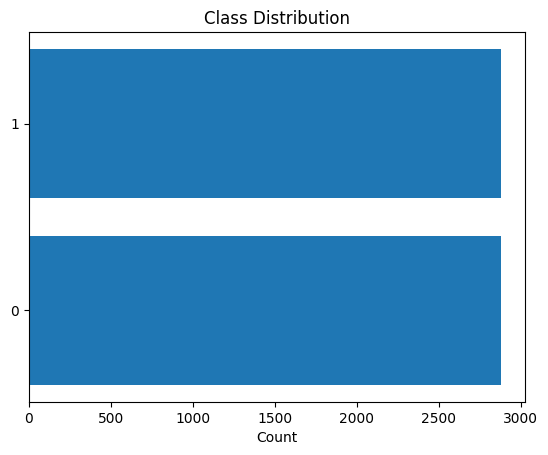

In [13]:
plot_class_distribution(smote_50_50_loader)

## Evaluating MLP with the 50-50 SMOTE dataset

In [14]:
for X, y in smote_50_50_loader:
    X_np = X.numpy()
    y_np = y.numpy()
    if X_res.size == 0:
        X_res = X_np
        y_res = y_np
    else:
        X_res = np.vstack((X_res, X_np))
        y_res = np.concatenate((y_res, y_np))
X_train_smote, y_train_smote = X_res, y_res
X_train_smote = torch.tensor(X_train_smote, dtype=torch.float32)
y_train_smote = torch.tensor(y_train_smote, dtype=torch.long)

Training: 100%|██████████| 100/100 [00:06<00:00, 14.37it/s]

Final Loss: 0.6360, Precision: 0.6430, Recall: 0.6793


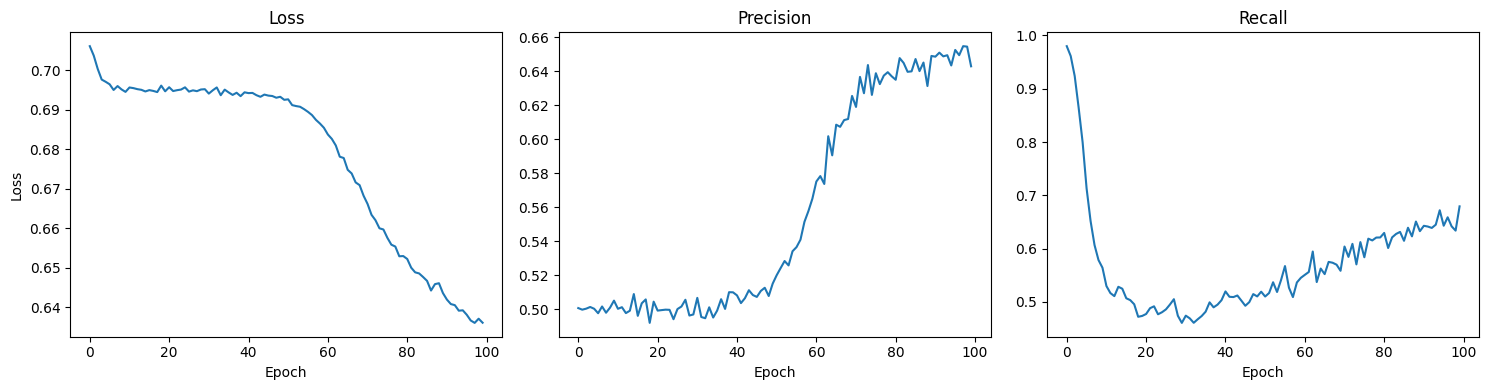

In [15]:
X_dim_smote = next(iter(smote_50_50_loader))[0].shape[1]
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
default_model_smote = ECE228MLP(X_dim_smote).to(device)
X_train_smote = X_train_smote.to(device)
y_train_smote = y_train_smote.to(device)
l2_train_and_plot(default_model_smote, X_train_smote, y_train_smote, epochs=100, lr=1e-4, batch_size=1024)

In [16]:
evaluate(default_model_smote, X_test.to(device), y_test.to(device))

Test Loss:      0.6111
Test Accuracy:  0.6875
Test Precision: 0.2805
Test Recall:    0.6439
Test F1 Score:  0.3908


0.39080459770114945

## SMOTE Conclusions

- As we can see, SMOTE noticeably improved the model performance when compared to the barebores L2 regularised model and substantially over the non regularised model.

## Finding the best SMOTE Parameter

- As we noted earlier, the SMOTE parameter of 50-50 may not be ideal. We will perform a grid search to find the best SMOTE parameter.

In [17]:
from imblearn.over_sampling import SMOTE

def grid_search_smote(mlp_cls, X_train, y_train, X_test, y_test, device,
                      sampling_strategies=None, epochs=100, lr=1e-4, batch_size=1024):
    if sampling_strategies is None:
        sampling_strategies = np.linspace(0.2, 1.0, 20)

    results = {}
    best_model = None
    best_f1 = -1
    best_strategy = None

    X_test, y_test = X_test.to(device), y_test.to(device)

    for s in sampling_strategies:
        sm = SMOTE(random_state=0, sampling_strategy=s)
        Xr, yr = sm.fit_resample(X_train.cpu().numpy(), y_train.cpu().numpy())
        Xr = torch.tensor(Xr, dtype=X_train.dtype).to(device)
        yr = torch.tensor(yr, dtype=y_train.dtype).to(device)

        model = mlp_cls(Xr.shape[1]).to(device)
        l2_train_and_plot(model, Xr, yr, epochs=epochs, lr=lr, batch_size=batch_size)

        f1 = evaluate(model, X_test, y_test)
        results[s] = f1

        if f1 > best_f1:
            best_f1 = f1
            best_strategy = s
            best_model = model

    print(f'Best sampling_strategy={best_strategy:.2f}, F1={best_f1:.4f}')
    return best_strategy, results, best_model

Training: 100%|██████████| 100/100 [00:02<00:00, 42.44it/s]


Final Loss: 0.4706, Precision: 0.0000, Recall: 0.0000


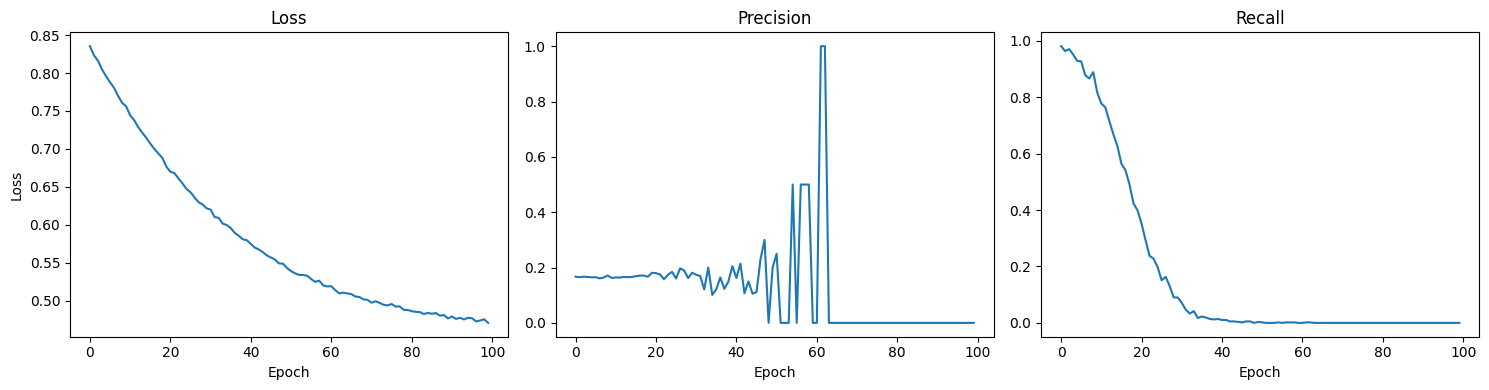

Test Loss:      0.4527
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:02<00:00, 42.92it/s]

Final Loss: 0.5167, Precision: 0.0000, Recall: 0.0000


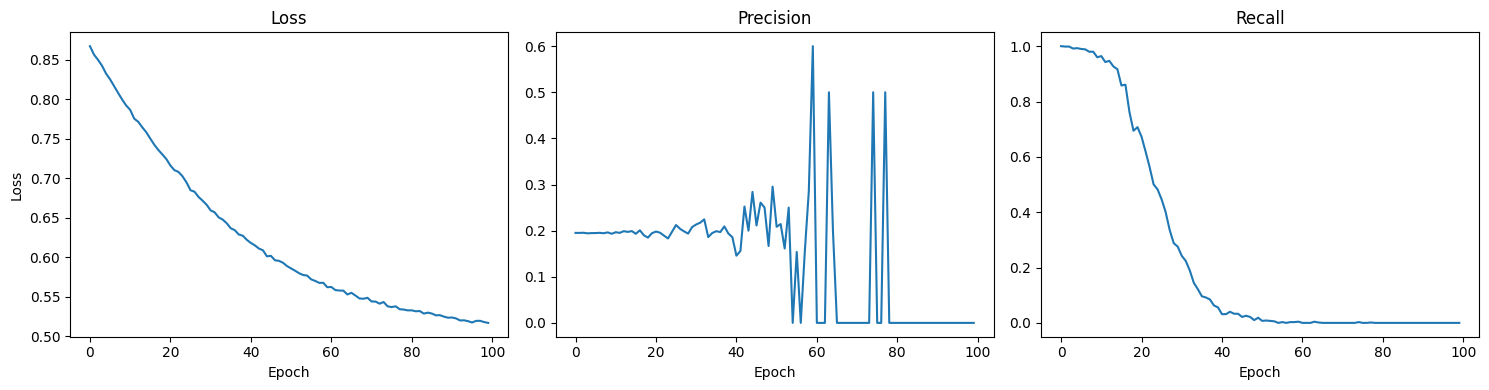

Test Loss:      0.4723
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:02<00:00, 43.08it/s]


Final Loss: 0.5323, Precision: 0.0000, Recall: 0.0000


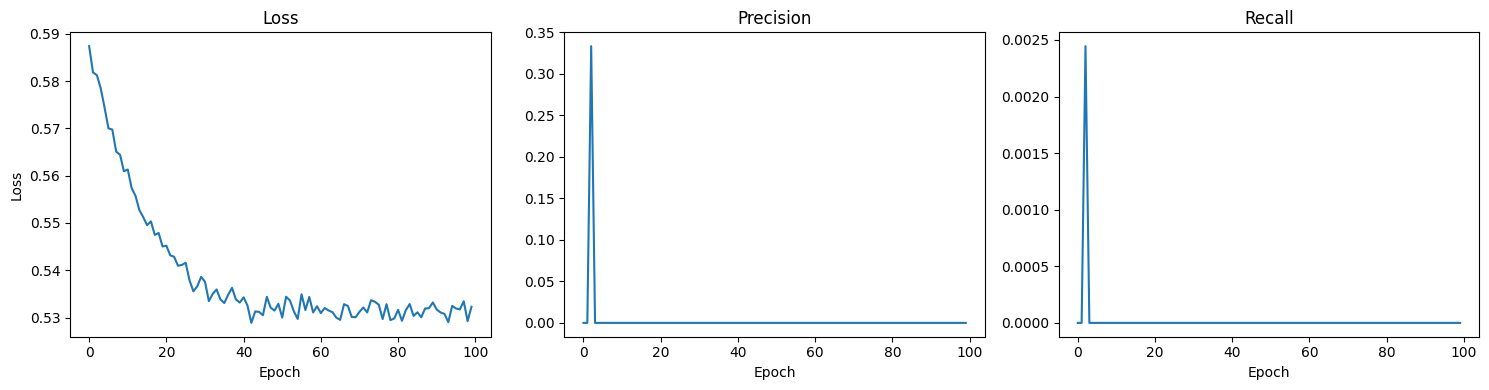

Test Loss:      0.4453
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:02<00:00, 41.25it/s]

Final Loss: 0.5604, Precision: 0.0000, Recall: 0.0000


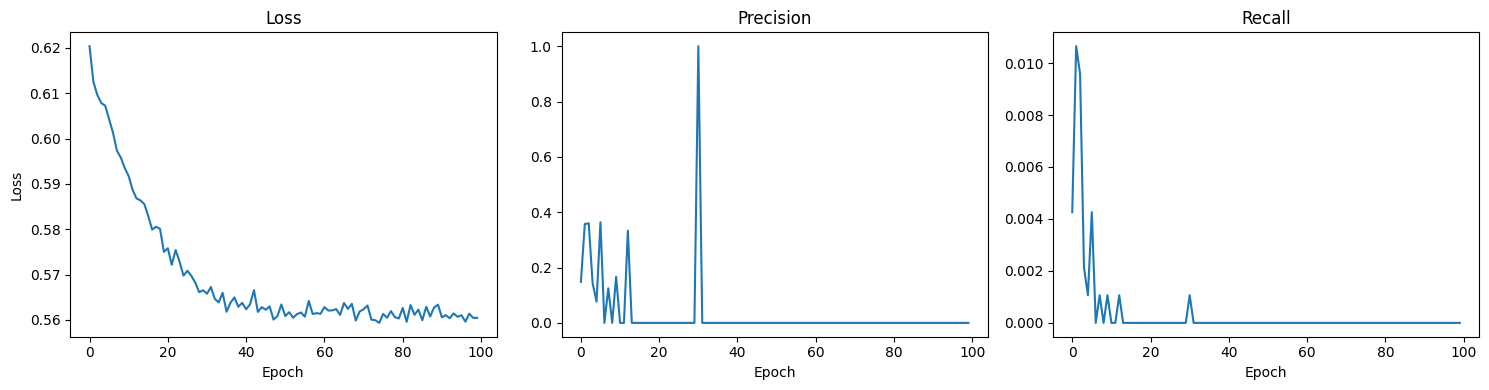

Test Loss:      0.4563
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:02<00:00, 41.66it/s]


Final Loss: 0.5861, Precision: 0.0000, Recall: 0.0000


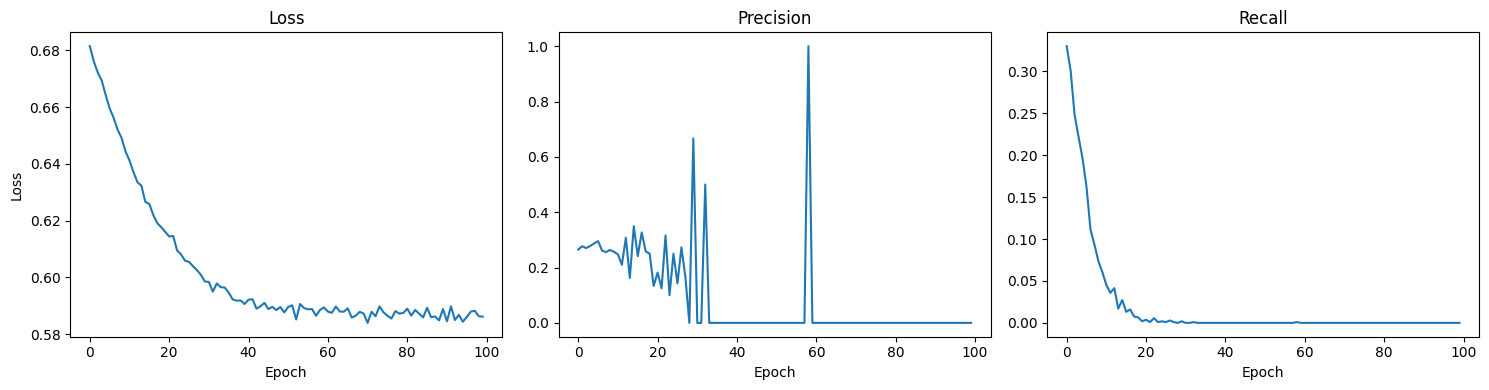

Test Loss:      0.4685
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:02<00:00, 41.68it/s]


Final Loss: 0.6081, Precision: 0.0000, Recall: 0.0000


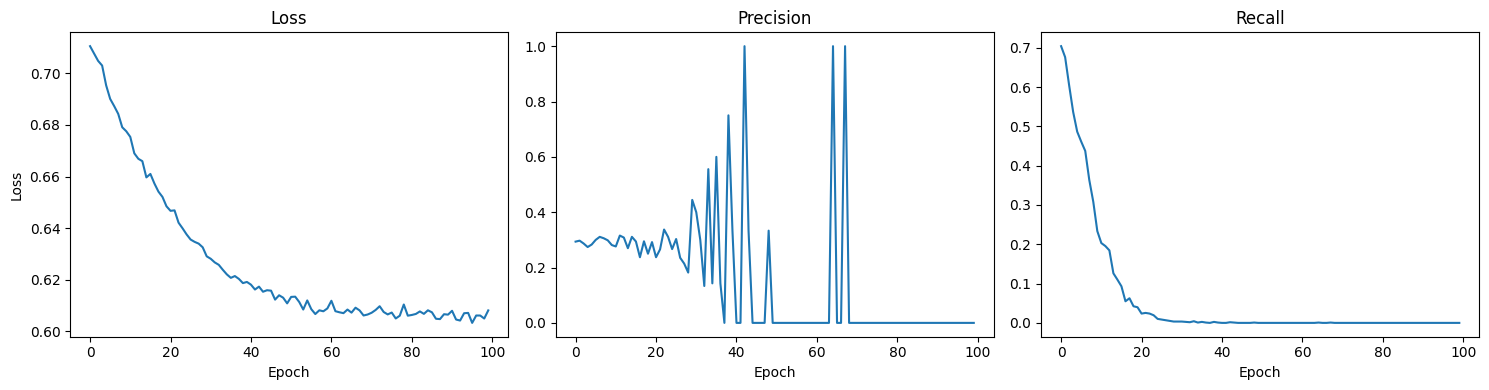

Test Loss:      0.4841
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:02<00:00, 34.03it/s]


Final Loss: 0.6258, Precision: 0.0000, Recall: 0.0000


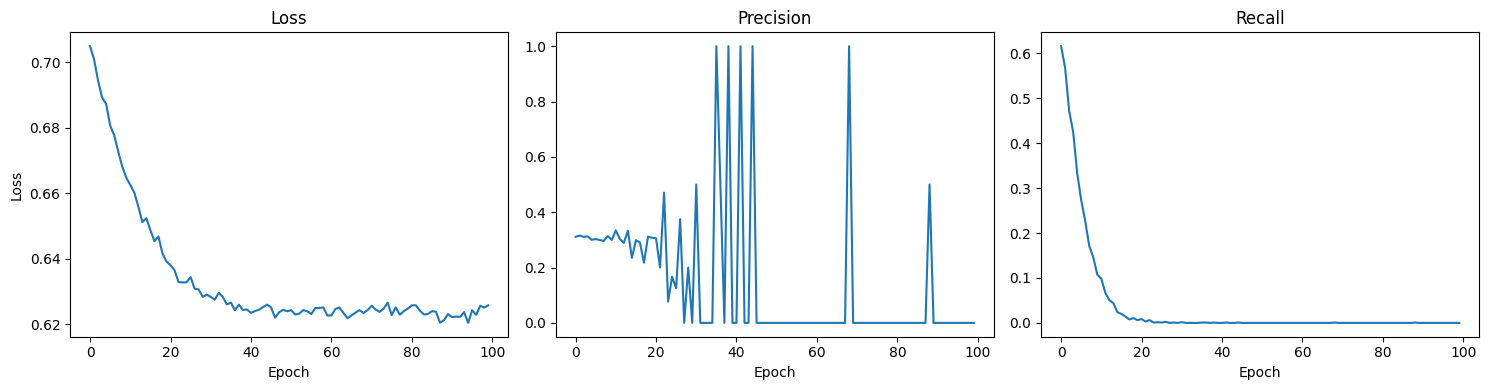

Test Loss:      0.4936
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:03<00:00, 32.60it/s]


Final Loss: 0.6363, Precision: 0.0000, Recall: 0.0000


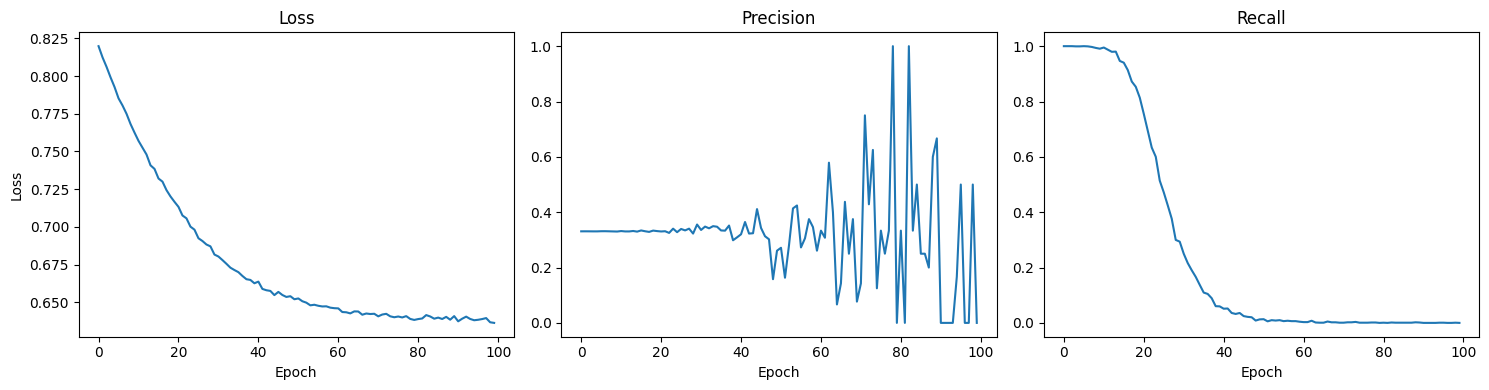

Test Loss:      0.5202
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:02<00:00, 34.22it/s]


Final Loss: 0.6492, Precision: 0.6667, Recall: 0.0013


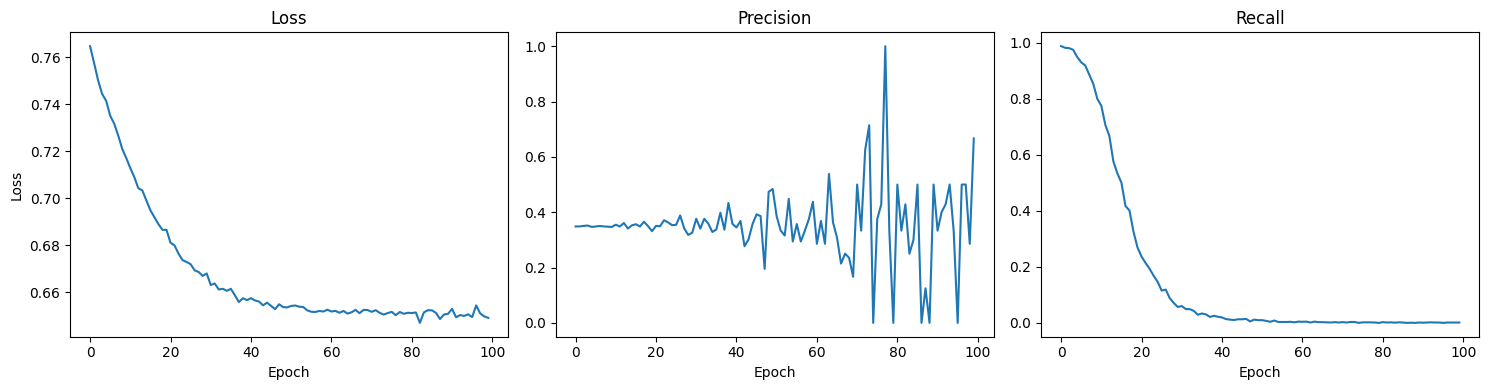

Test Loss:      0.5261
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:03<00:00, 29.92it/s]


Final Loss: 0.6607, Precision: 0.2857, Recall: 0.0012


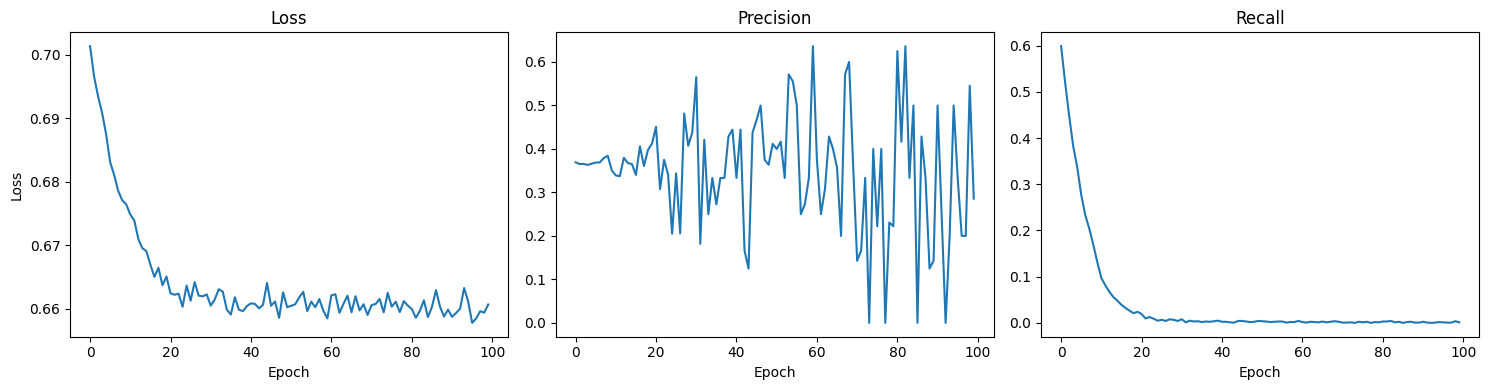

Test Loss:      0.5417
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:02<00:00, 33.90it/s]


Final Loss: 0.6662, Precision: 0.3333, Recall: 0.0006


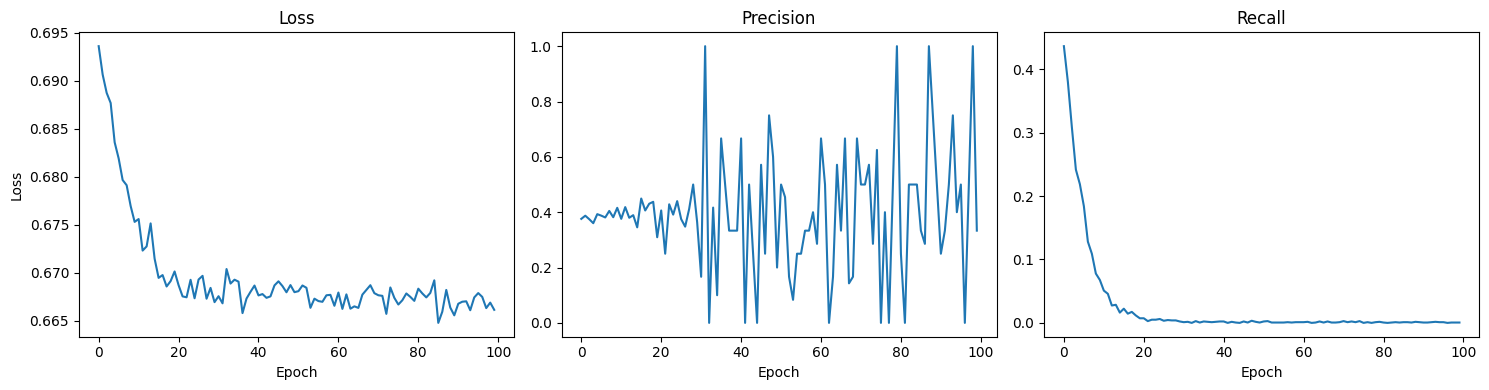

Test Loss:      0.5559
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:02<00:00, 33.79it/s]


Final Loss: 0.6725, Precision: 0.0000, Recall: 0.0000


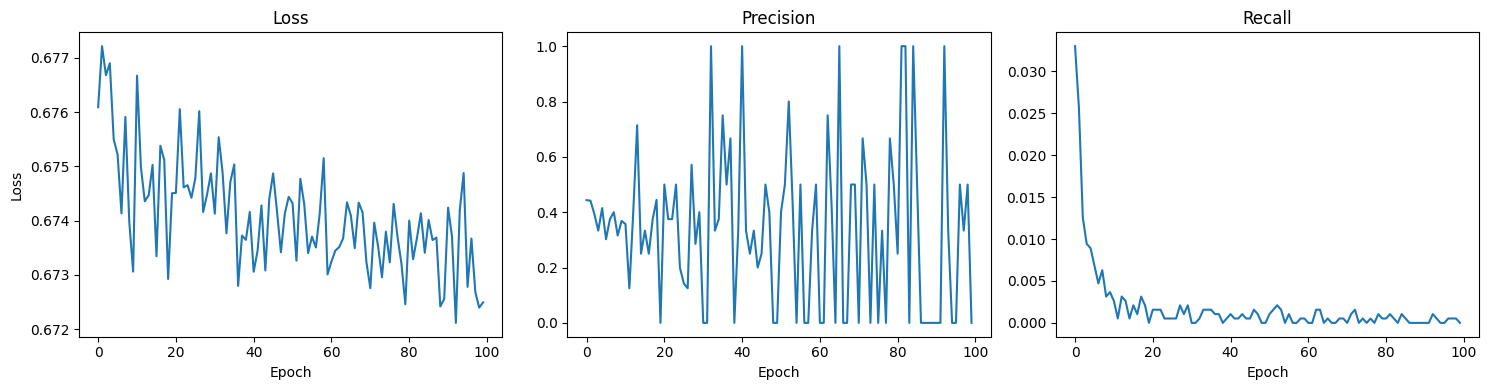

Test Loss:      0.5712
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:02<00:00, 33.87it/s]


Final Loss: 0.6787, Precision: 0.5833, Recall: 0.0034


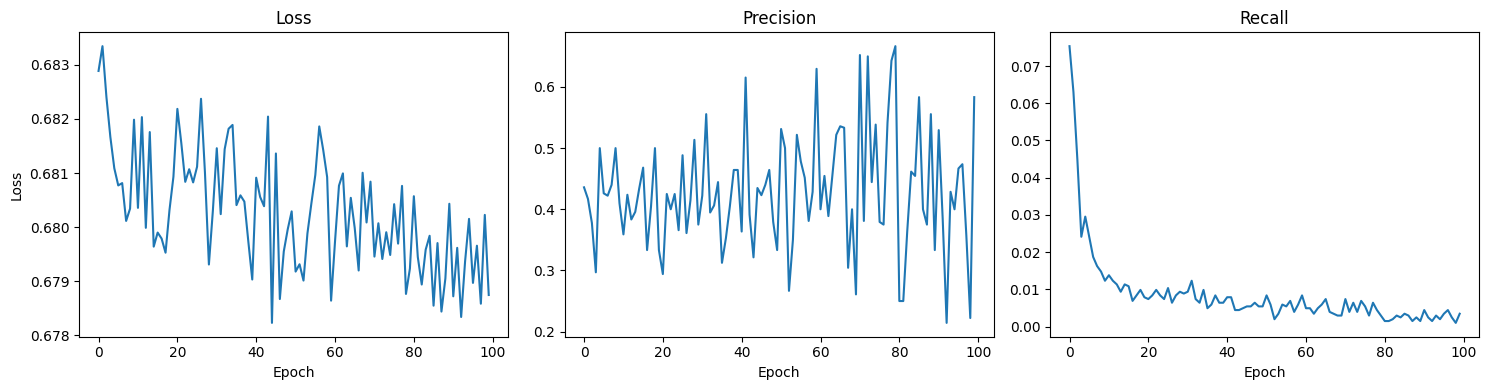

Test Loss:      0.5877
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:02<00:00, 34.14it/s]


Final Loss: 0.6848, Precision: 0.3953, Recall: 0.0079


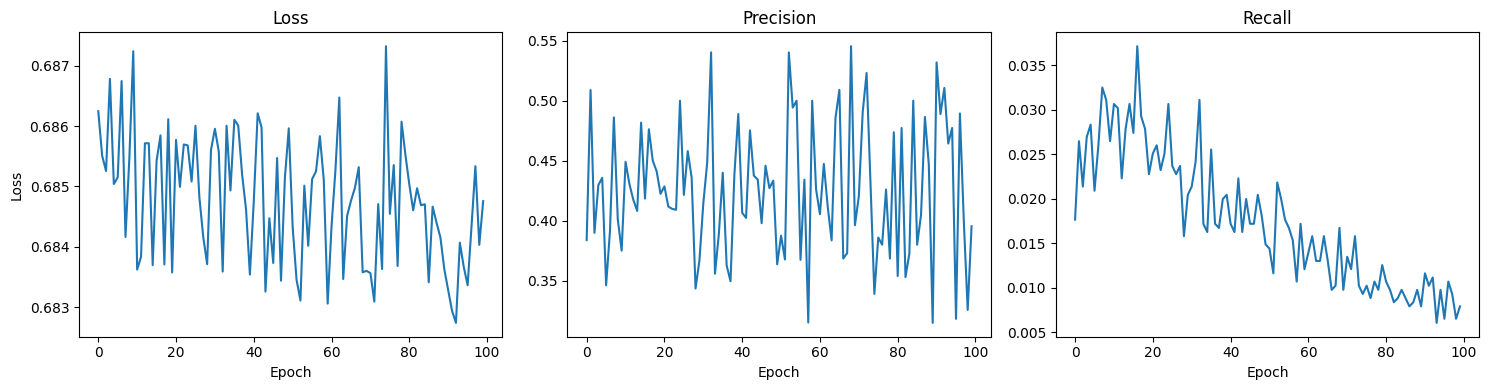

Test Loss:      0.6038
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:03<00:00, 28.84it/s]


Final Loss: 0.6880, Precision: 0.4310, Recall: 0.0330


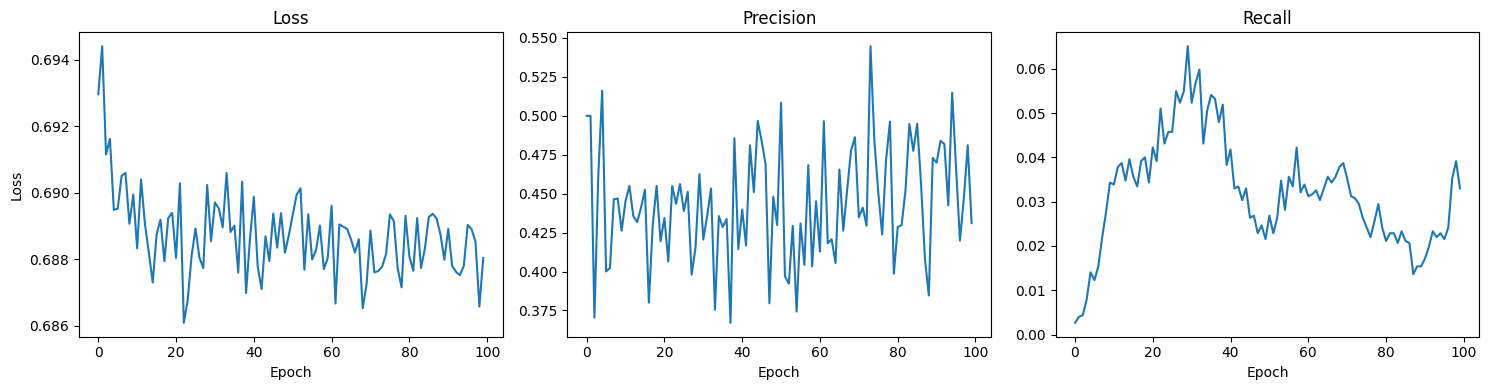

Test Loss:      0.6220
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:03<00:00, 27.90it/s]

Final Loss: 0.6896, Precision: 0.4731, Recall: 0.0773


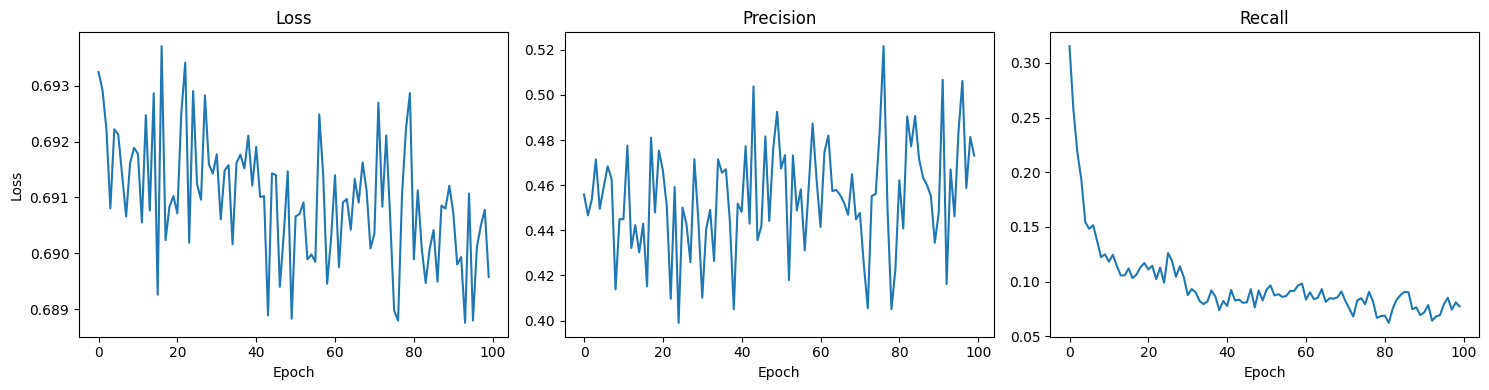

Test Loss:      0.6357
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Final Loss: 0.6922, Precision: 0.5020, Recall: 0.2043


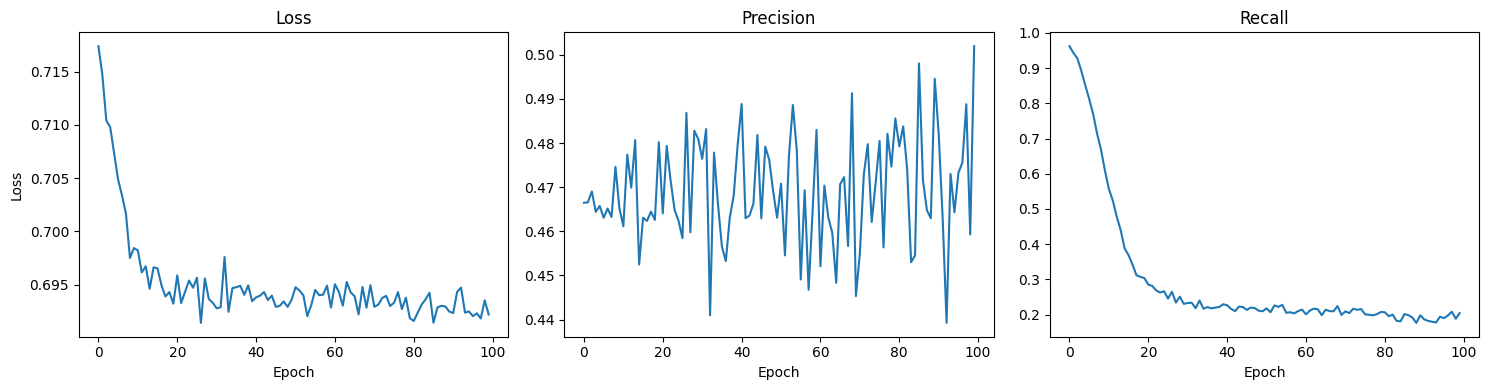

Test Loss:      0.6469
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:03<00:00, 26.62it/s]


Final Loss: 0.6924, Precision: 0.4923, Recall: 0.2541


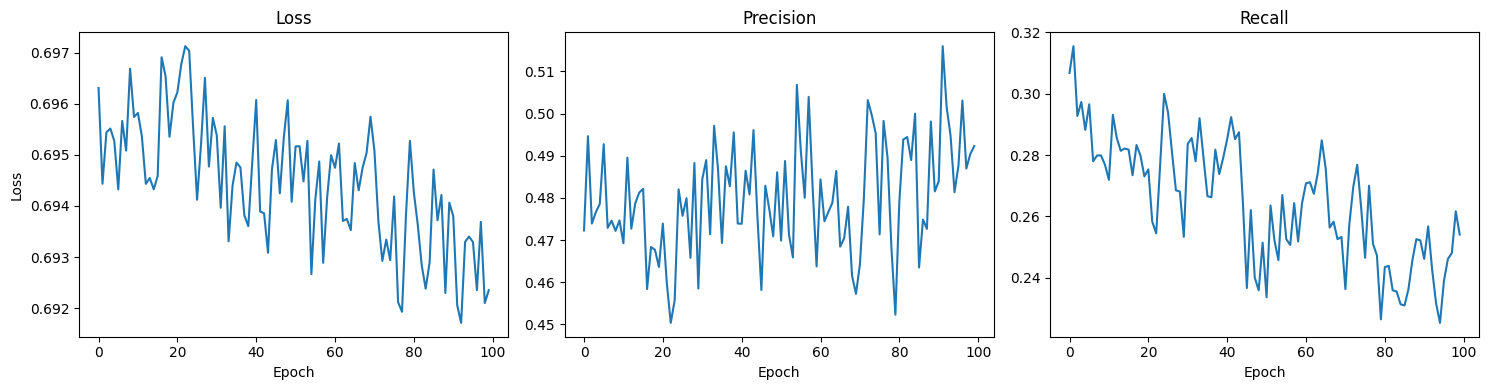

Test Loss:      0.6629
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:03<00:00, 25.94it/s]

Final Loss: 0.6960, Precision: 0.4811, Recall: 0.3742


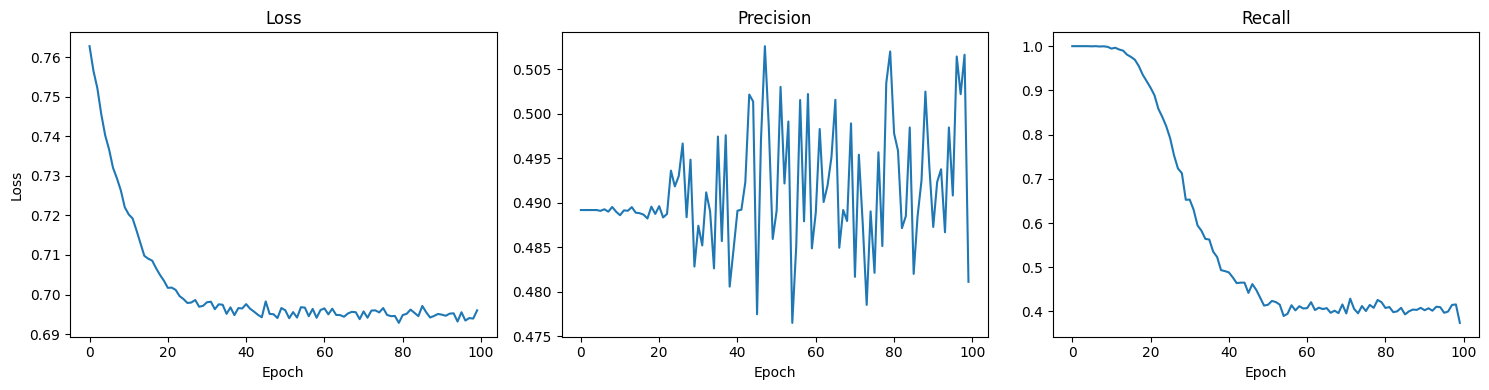

Test Loss:      0.6761
Test Accuracy:  0.8443
Test Precision: 0.0000
Test Recall:    0.0000
Test F1 Score:  0.0000


Training: 100%|██████████| 100/100 [00:03<00:00, 26.49it/s]

Final Loss: 0.6929, Precision: 0.5147, Recall: 0.4927


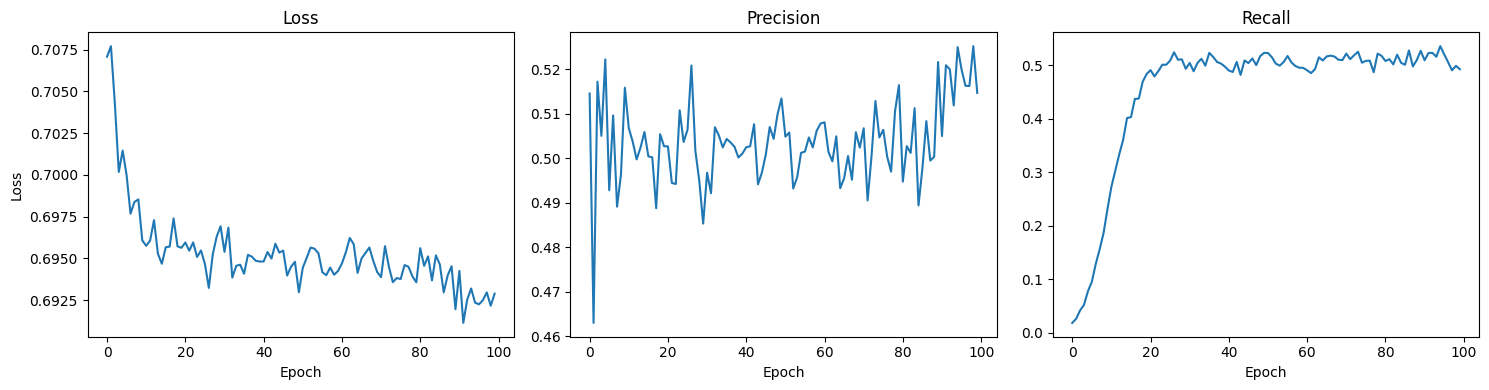

Test Loss:      0.6900
Test Accuracy:  0.6757
Test Precision: 0.2381
Test Recall:    0.4924
Test F1 Score:  0.3210
Best sampling_strategy=1.00, F1=0.3210


In [18]:
_, _, best_model = grid_search_smote(ECE228MLP, X_train, y_train, X_test, y_test, device)

## Getting the best model

In [19]:
evaluate(best_model, X_test.to(device), y_test.to(device))

Test Loss:      0.6900
Test Accuracy:  0.6757
Test Precision: 0.2381
Test Recall:    0.4924
Test F1 Score:  0.3210


0.3209876543209876

## Best Model Conclusions

- The best model retrieved from the Grid Search performs noticeably better than the initial model in terms of F1 score.

## Grid Search Conclusions

- We can see that sampling strategy of <TODO: Enter best sampling strategy> yielded the best results. This means the ideal test set result occurs when the minority class was <TODO: Enter best sampling strategy>x as big as the majority set. And this F1 score is greater than the L2 score, so SMOTE improved the performance of the dataset.

# Ensembling Strategies

- Here we evaluate various statistical strategies and see how we can ensemble them into a final model. We consider Decision Trees and KNNs.

### Decision Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_split=40, # adjusted based on grid search results
    random_state=0
)
dt.fit(X_train_smote.cpu(), y_train_smote.cpu())

acc = accuracy_score(y_test, dt.predict(X_test))
prec = precision_score(y_test, dt.predict(X_test))
rec = recall_score(y_test, dt.predict(X_test))
f1 = f1_score(y_test, dt.predict(X_test))

print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall:    {rec:.4f}")
print(f"Test F1 Score:  {f1:.4f}")

Test Accuracy:  0.7630
Test Precision: 0.2621
Test Recall:    0.2879
Test F1 Score:  0.2744


### KNN Classifier

In [21]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier(n_neighbors=84) # adjusted based on grid search results
knn.fit(X_train_smote.cpu(), y_train_smote.cpu())

y_pred = knn.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall:    {rec:.4f}")
print(f"Test F1 Score:  {f1:.4f}")

Test Accuracy:  0.6179
Test Precision: 0.2333
Test Recall:    0.6364
Test F1 Score:  0.3415


## Classifier Conclusions

- We can see that KNN and Decision Trees perform nearly identically. No noticeable difference. We now ensemble these classifiers with the final MLP to get a final test accuracy.

### Modal Ensembling

In [22]:
import torch
import numpy as np
from sklearn.metrics import f1_score

def ensemble_predict(mlp, knn, dt, X, batch_size=32):
    device = next(mlp.parameters()).device
    mlp.eval()
    mlp_preds = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            xb = X[i:i+batch_size].to(device)
            logits = mlp(xb).view(-1)
            mlp_preds.append((torch.sigmoid(logits) > 0.5).long().cpu().numpy())
    mlp_preds = np.concatenate(mlp_preds)

    X_np = X.cpu().numpy()
    knn_preds = knn.predict(X_np)
    dt_preds  = dt.predict(X_np)

    votes = np.stack([mlp_preds, knn_preds, dt_preds], axis=1)
    ensemble = (votes.sum(axis=1) >= 2).astype(int)
    return ensemble

def evaluate_ensemble(mlp, knn, dt, X_test, Y_test):
    y_true = Y_test.cpu().numpy().astype(int)
    y_pred = ensemble_predict(mlp, knn, dt, X_test)
    f1 = f1_score(y_true, y_pred)
    print(f'Ensemble F1 Score: {f1:.4f}')
    return f1

In [23]:
evaluate_ensemble(best_model, knn, dt, X_test.to(device), y_test.to(device))

Ensemble F1 Score: 0.3743


np.float64(0.3743016759776536)

## Ensembling Conclusions

- Ensembling gives a marked improvement over the standard models, but the L2 + Grid Searched MLP clearly outperforms the traditional statistical methods, so the ensembling provides no benefits (if not a degradation) over the MLP. So, we can conclude that the MLP alone is the best performer.